# 1. Look at the Big picture

## Frame the problem
* Supervised Learning : label 
* Classification task : To classify if the news is fake or real
* Batch Learning : No continuous flow of data, no. hanging data rapidly, and small enough to fit in memory

---------------------------------------------------
# 2. Get the Data

* Download the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pandas.plotting import scatter_matrix
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'hhzet11'
os.environ['KAGGLE_KEY'] = "2698b4a5f39bb4b8c96d4af086aeb254"

In [ ]:
!kaggle competitions download -c fake-news
!unzip '*.zip'
!ls

 39% 18.0M/46.5M [00:00<00:00, 186MB/s]
100% 46.5M/46.5M [00:00<00:00, 245MB/s]
Archive:  fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               
fake-news.zip  sample_data  submit.csv	test.csv  train.csv


* Load the data using pandas

In [ ]:
df = pd.read_csv('train.csv')

# 3. Discover and Visualize the data to. gain insights

* Take a quick look at the data structure

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
df.shape

(20800, 5)

* Draw Histogram for numeric values

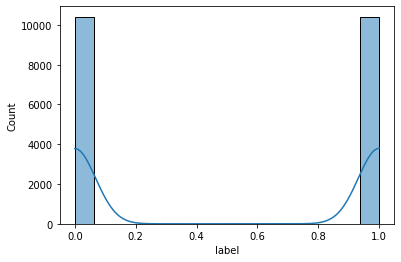

In [ ]:
sns.histplot(x = 'label', data = df, kde = True)

* Look for Correlations

In [ ]:
corr_matrix = df.corr()

In [ ]:
corr_matrix['label'].sort_values(ascending = False)

label    1.00000
id       0.00114
Name: label, dtype: float64

# 4. Prepare the Data for Machine Learning Algorithms

* Fill empty values

In [ ]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
# replacing the null values with empty string
df = df.fillna('')
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
# merging the author name and news title
df['content'] = df['author'] + ' ' + df['title']
print(df['content'].head())

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: content, dtype: object


* Split the label we want to predict

In [ ]:
X = df.drop(columns = 'label', axis = 1)
Y = pd.DataFrame(df['label'])
print(X.head())

   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1  Ever get the feeling your life circles the rou...   
2  Why the Truth Might Get You Fired October 29, ...   
3  Videos 15 Civilians Killed In Single US Airstr...   
4  Print \nAn Iranian woman has been sentenced to...   

                                             content  
0  Darrell Lucus House Dem Aide: We Didn’t Even S...  
1  Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...  
2  Consortiumnews

In [ ]:
print(Y)

       label
0          1
1          0
2          1
3          1
4          1
...      ...
20795      0
20796      0
20797      0
20798      1
20799      1

[20800 rows x 1 columns]


* Stemming

In [ ]:
port_stem = PorterStemmer()
def stemming(content) :
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
df['content'] = df['content'].apply(stemming)
print(df['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


* Separating the data and label

In [ ]:
X = df['text'].values
Y = df['label'].values
print(X)

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing ema

In [ ]:
print(Y)

[1 0 1 ... 0 1 1]


In [ ]:
Y.shape

(20800,)

* Encoding words to numbers

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X)

  (0, 153872)	0.008917324755964462
  (0, 153526)	0.04525694700538712
  (0, 153477)	0.010481516602223042
  (0, 153467)	0.010985819002751846
  (0, 152391)	0.04075129071622209
  (0, 152385)	0.08744923236839197
  (0, 152317)	0.03488076752649891
  (0, 152259)	0.0128116266838325
  (0, 151769)	0.026030620204596174
  (0, 151598)	0.024099308037638646
  (0, 151344)	0.00844977869471337
  (0, 150983)	0.03819114847800876
  (0, 150773)	0.008297181008050039
  (0, 150740)	0.02606194149968498
  (0, 150678)	0.025645129931467555
  (0, 150419)	0.01575717573710974
  (0, 150309)	0.011666528031125091
  (0, 150195)	0.026967418755208483
  (0, 150091)	0.01324965093514316
  (0, 149921)	0.057384548118919576
  (0, 149844)	0.01139913947063961
  (0, 149616)	0.05646716940798761
  (0, 148717)	0.026281365915191385
  (0, 148691)	0.019899039240389806
  (0, 148667)	0.01626410083038377
  :	:
  (20799, 6880)	0.014580717229874772
  (20799, 6797)	0.03602806675031722
  (20799, 6424)	0.011485155705407726
  (20799, 5581)	0.01709

# 5. Select and Train the Model

* Split the dataset to train & test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 1)

* Training the Model : Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

* Evaluation

In [ ]:
prediction = model.predict(X_test)

In [ ]:
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3116
           1       0.93      0.95      0.94      3124

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



* Testing the Predictive System

In [ ]:
X_new = X_test[2]

prediction = model.predict(X_new)
print(prediction)

if prediction[0] == 0 :
  print('The news is Real')
else :
  print('The news is Fake')

[1]
The news is Fake


In [ ]:
print(Y_test[2])

1


# 6. Fine-Tune Model

* Fine tune model with XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model_xgb = XGBClassifier()

In [ ]:
model_xgb.fit(X_train, Y_train)

XGBClassifier()

In [ ]:
pred = model_xgb.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3116
           1       0.92      0.94      0.93      3124

    accuracy                           0.93      6240
   macro avg       0.93      0.93      0.93      6240
weighted avg       0.93      0.93      0.93      6240

